### Test on 2017

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel
from darts.metrics import mape, mae, rmse
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values

sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2010-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

series = fill_missing_values(series) # fill missing values

# split into train (up to 2012-2016) and test (2017)
train_ts, test_ts = series.split_before(pd.Timestamp("2017-01-01"))

scaler       = Scaler()                              # name, params internally managed
train_scaled = scaler.fit_transform(train_ts)        # fit on train
test_scaled  = scaler.transform(test_ts)             # same transform on test

C:\Users\USER\AppData\Local\Temp\ipykernel_13892\2844960218.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [5]:
# Instantiate and train the Random Forest model with 12 lags
model = TCNModel(
    input_chunk_length=60,
    output_chunk_length=5,
    kernel_size=3,
    num_filters=64,
    num_layers=4,
    dilation_base=2,
    dropout=0.1,
    weight_norm=True,
    batch_size=32,
    n_epochs=120,
    optimizer_kwargs={"lr": 1e-3},
    lr_scheduler_kwargs={"factor": 0.5, "patience": 10},
    nr_epochs_val_period=5,
    pl_trainer_kwargs={"gradient_clip_val": 1.0, # Prevent runaway update, clipping gradients at a norm of 1
                        "accelerator": "gpu",
                        "devices": 1},  
    random_state=42
)

# fit and forecast
h = len(test_ts)
model.fit(train_scaled, verbose=True)
forecast_scaled = model.predict(n=h)
forecast = scaler.inverse_transform(forecast_scaled)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 75.2 K | train
-------------------------------------------------------------
75.2 K    Trainable params
0         Non-trainable params
75.2 K    Total params
0.301     Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=120` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

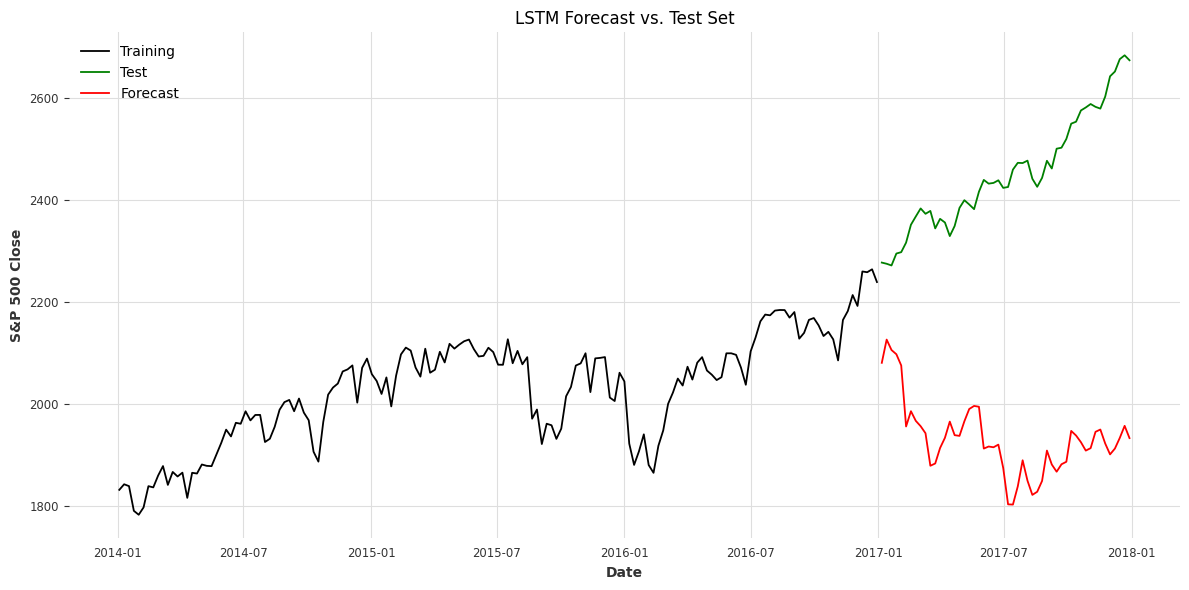

MAPE: 21.01%
MAE:  520.37
RMSE: 542.83



In [7]:
# get only the part of train_ts from 2014-01-01 onward
train_slice = train_ts.slice(pd.Timestamp("2014-01-01"), train_ts.end_time())

# plot train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_slice.time_index, train_slice.values(), label="Training")
plt.plot(test_ts.time_index, test_ts.values(), label="Test", color="green")
plt.plot(forecast.time_index, forecast.values(), label="Forecast", color="red")

plt.title("LSTM Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

print(f"MAPE: {mape(test_ts, forecast):.2f}%")
print(f"MAE:  {mae(test_ts, forecast):.2f}")
print(f"RMSE: {rmse(test_ts, forecast):.2f}\n")

### Test on 2023 and 2024